In [1]:
import plotly.plotly as py
import plotly.graph_objs as graph_objs

import cufflinks as cf

import pandas as pd
import numpy as np

import sqlite3
from sqlalchemy import create_engine

In [2]:
engine = create_engine('sqlite:///liligo.db', echo=False)

# Let's see how prices go up for a weekend in February
we only have one snapshot per month, so the analysis won't be exact, and have to apply some approximations
* first check the price of the second weekend in February (8-10), booked at different times -- one date per month from sep to dec
* next check how the price of the consecutive weekends changes (feb 8-10, feb 15-17  and feb 22-24)

In [3]:
dates = [('2019-02-08', '2019-02-10'), ('2019-02-15', '2019-02-17'), ('2019-02-22', '2019-02-24')]
months = ['feb', 'jan', 'dec', 'nov', 'oct', 'sep']

In [81]:
mapper = {'2019-02-08': '<1 week left', '2019-02-15': '2 weeks left', '2019-02-22':'3 weeks left'}
mapper

{'2019-02-08': '<1 week left',
 '2019-02-15': '2 weeks left',
 '2019-02-22': '3 weeks left'}

### Bottom percentile

In [4]:
for (date_from, date_to) in dates:
    q3_list = []
    cnt_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as q3_price_per_night
            from cal
            order by q3_price_per_night
            limit 1
            offset (select count(*) from cal) / 4
        '''.format('calendar_' + month, date_from, date_to)
        q3 = pd.read_sql_query(sql, engine)
        q3_list.append((month, q3.loc[0, 'q3_price_per_night']))
        
        sql = '''
            select count(*) as cnt
            from (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 
        '''.format('calendar_' + month, date_from, date_to)
        cnt = pd.read_sql_query(sql, engine)
        cnt_list.append((month, cnt.loc[0, 'cnt']))
    
    print(date_from, date_to)
    print('bottom 25 percentile price: ', q3_list)
    print('number of listings for the weened: ',  cnt_list)
    print()

2019-02-08 2019-02-10
bottom 25 percentile price:  [('feb', 80.0), ('jan', 78.0), ('dec', 75.0), ('nov', 74.0), ('oct', 70.0), ('sep', 69.0)]
number of listings for the weened:  [('feb', 6633), ('jan', 11143), ('dec', 14600), ('nov', 14115), ('oct', 15961), ('sep', 18448)]

2019-02-15 2019-02-17
bottom 25 percentile price:  [('feb', 80.0), ('jan', 78.0), ('dec', 75.0), ('nov', 74.0), ('oct', 70.0), ('sep', 69.0)]
number of listings for the weened:  [('feb', 7531), ('jan', 11213), ('dec', 14732), ('nov', 14094), ('oct', 16030), ('sep', 18603)]

2019-02-22 2019-02-24
bottom 25 percentile price:  [('feb', 79.0), ('jan', 75.0), ('dec', 72.0), ('nov', 74.0), ('oct', 70.0), ('sep', 69.0)]
number of listings for the weened:  [('feb', 9324), ('jan', 12382), ('dec', 15587), ('nov', 14600), ('oct', 16456), ('sep', 18935)]



In [8]:
q3_prices = (
    pd.concat([
        (
            pd
            .DataFrame([('feb', 80.0), ('jan', 78.0), ('dec', 75.0), ('nov', 74.0), ('oct', 70.0), ('sep', 69.0)], columns = ['month', 'q3_price_1w'])
            .set_index('month')
        ),
        (
            pd
            .DataFrame([('feb', 80.0), ('jan', 78.0), ('dec', 75.0), ('nov', 74.0), ('oct', 70.0), ('sep', 69.0)], columns = ['month', 'q3_price_2w'])
            .set_index('month')
        ),
        (
            pd
            .DataFrame([('feb', 79.0), ('jan', 75.0), ('dec', 72.0), ('nov', 74.0), ('oct', 70.0), ('sep', 69.0)], columns = ['month', 'q3_price_3w'])
            .set_index('month')
        )
    ], axis = 1)
    [::-1]
)
q3_prices

,q3_price_1w,q3_price_2w,q3_price_3w
month,,,
sep,69.0,69.0,69.0
oct,70.0,70.0,70.0
nov,74.0,74.0,74.0
dec,75.0,75.0,72.0
jan,78.0,78.0,75.0
feb,80.0,80.0,79.0


### Median

In [5]:
for (date_from, date_to) in dates:
    q4_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as median_price_per_night
            from cal
            order by median_price_per_night
            limit 1
            offset (select count(*) from cal) / 2
        '''.format('calendar_' + month, date_from, date_to)
        q4 = pd.read_sql_query(sql, engine)
        q4_list.append((month, q4.loc[0, 'median_price_per_night']))
    
    print(date_from, date_to)
    print('median percentile price: ', q4_list)
    print()

2019-02-08 2019-02-10
median percentile price:  [('feb', 115.0), ('jan', 110.0), ('dec', 100.0), ('nov', 105.0), ('oct', 100.0), ('sep', 98.0)]

2019-02-15 2019-02-17
median percentile price:  [('feb', 114.0), ('jan', 110.0), ('dec', 100.0), ('nov', 102.0), ('oct', 100.0), ('sep', 98.0)]

2019-02-22 2019-02-24
median percentile price:  [('feb', 110.0), ('jan', 110.0), ('dec', 100.0), ('nov', 103.0), ('oct', 100.0), ('sep', 98.0)]



In [9]:
median_prices = (
    pd.concat([
        (
            pd
            .DataFrame([('feb', 115.0), ('jan', 110.0), ('dec', 100.0), ('nov', 105.0), ('oct', 100.0), ('sep', 98.0)], columns = ['month', 'median_price_1w'])
            .set_index('month')
        ),
        (
            pd
            .DataFrame([('feb', 114.0), ('jan', 110.0), ('dec', 100.0), ('nov', 102.0), ('oct', 100.0), ('sep', 98.0)], columns = ['month', 'median_price_2w'])
            .set_index('month')
        ),
        (
            pd
            .DataFrame([('feb', 110.0), ('jan', 110.0), ('dec', 100.0), ('nov', 103.0), ('oct', 100.0), ('sep', 98.0)], columns = ['month', 'median_price_3w'])
            .set_index('month')
        )
    ], axis = 1)
    [::-1]
)
median_prices

,median_price_1w,median_price_2w,median_price_3w
month,,,
sep,98.0,98.0,98.0
oct,100.0,100.0,100.0
nov,105.0,102.0,103.0
dec,100.0,100.0,100.0
jan,110.0,110.0,110.0
feb,115.0,114.0,110.0


### Top percentile

In [7]:
for (date_from, date_to) in dates:
    q1_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as q1_price_per_night
            from cal
            order by q1_price_per_night
            limit 1
            offset (select count(*) from cal) / 4 * 3
        '''.format('calendar_' + month, date_from, date_to)
        q1 = pd.read_sql_query(sql, engine)
        q1_list.append((month, q1.loc[0, 'q1_price_per_night']))

    
    print(date_from, date_to)
    print('top 25 percentile price: ', q1_list)
    print()

2019-02-08 2019-02-10
top 25 percentile price:  [('feb', 190.0), ('jan', 175.0), ('dec', 161.0), ('nov', 170.0), ('oct', 160.0), ('sep', 150.0)]

2019-02-15 2019-02-17
top 25 percentile price:  [('feb', 189.0), ('jan', 175.0), ('dec', 160.0), ('nov', 169.0), ('oct', 160.0), ('sep', 150.0)]

2019-02-22 2019-02-24
top 25 percentile price:  [('feb', 180.0), ('jan', 170.0), ('dec', 160.0), ('nov', 170.0), ('oct', 160.0), ('sep', 150.0)]



In [10]:
q1_prices = (
    pd.concat([
        (
            pd
            .DataFrame([('feb', 190.0), ('jan', 175.0), ('dec', 161.0), ('nov', 170.0), ('oct', 160.0), ('sep', 150.0)], columns = ['month', 'q1_price_1w'])
            .set_index('month')
        ),
        (
            pd
            .DataFrame([('feb', 189.0), ('jan', 175.0), ('dec', 160.0), ('nov', 169.0), ('oct', 160.0), ('sep', 150.0)], columns = ['month', 'q1_price_2w'])
            .set_index('month')
        ),
        (
            pd
            .DataFrame([('feb', 180.0), ('jan', 170.0), ('dec', 160.0), ('nov', 170.0), ('oct', 160.0), ('sep', 150.0)], columns = ['month', 'q1_price_3w'])
            .set_index('month')
        )
    ], axis = 1)
    [::-1]
)
q1_prices

,q1_price_1w,q1_price_2w,q1_price_3w
month,,,
sep,150.0,150.0,150.0
oct,160.0,160.0,160.0
nov,170.0,169.0,170.0
dec,161.0,160.0,160.0
jan,175.0,175.0,170.0
feb,190.0,189.0,180.0


Take the average of the three weekends

In [36]:
(
    pd.concat([
        q1_prices.mean(axis=1).rename('top 25 perc price'),
        median_prices.mean(axis=1).rename('median price'), 
        q3_prices.mean(axis=1).rename('bottom 25 perc price'),
    ], axis = 1)
    .iplot(filename = 'paris_median_price', 
           mode = 'lines+markers',
           layout = graph_objs.Layout(yaxis = dict(range = (0, 200), tickformat = '$.0f'), 
                                      hovermode = 'closest',
                                      title = '<b>As the date comes closer, prices go up by 10-15%</b><br>Nightly price for a February weekend in Paris booked at different times'
                                     )
          )
)

# Number of listings

In [40]:
cnt_list = []
for month in months:
    if month == 'feb':
        continue
        
    sql = '''
        select count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '2019-02-08' and '2019-02-10'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 
    '''.format('calendar_' + month)
    cnt = pd.read_sql_query(sql, engine)
    cnt_list.append(('booked in ' + month, cnt.loc[0, 'cnt']))

print('number of listings for the weened: ',  cnt_list)

number of listings for the weened:  [('booked in jan', 11143), ('booked in dec', 14600), ('booked in nov', 14115), ('booked in oct', 15961), ('booked in sep', 18448)]


In [39]:
cnt_feb = []
for (date_from, date_to) in dates:
    sql = '''
        select count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from calendar_feb
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 
    '''.format(date_from, date_to)
    cnt = pd.read_sql_query(sql, engine)
    cnt_feb.append((mapper[date_from], cnt.loc[0, 'cnt']))

print('number of listings for the weened: ',  cnt_feb)

number of listings for the weened:  [('<1 week left', 6633), ('2 weeks left', 7531), ('3 weeks left', 9324)]


In [90]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 6633), ('2 weeks left', 7531), ('3 weeks left', 9324)], columns = ['month', 'count']),
        pd.DataFrame([('booked in jan', 11143), ('booked in dec', 14600), ('booked in nov', 14115), ('booked in oct', 15961), ('booked in sep', 18448)], columns = ['month', 'count'])
        ])
    .set_index('month')
    [::-1]
    .iplot(filename = 'paris_counts', kind = 'bar', dimensions = (10, 2),
           layout = graph_objs.Layout(title = '<b>Number of available places drop quickly in the last 4 weeks before the trip</b><br>Number of listings for a February weekend in Paris at different times', 
                                      hovermode = 'closest')
          )
)

# Break down by room type

### Booked at different months

In [19]:
cnt_list = []
for month in months:
    sql = '''
            select 
                  room.room_type as room_type
                , count(cal.listing_id) as cnt
            from (
                select listing_id
                from {} 
                where 1=1
                    and date between '2019-02-08' and '2019-02-10'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) cal
            join room_types room
                on cal.listing_id = room.id
            group by room.room_type
    '''.format('calendar_' + month)
    cnt = pd.read_sql_query(sql, engine)
    for ix, _ in cnt.iterrows():
        cnt_list.append(('booked in ' + month, cnt.loc[ix, 'room_type'], cnt.loc[ix, 'cnt']))

print('number of listings for the weened: ',  cnt_list)

number of listings for the weened:  [('booked in feb', 'Entire home/apt', 5166), ('booked in feb', 'Private room', 1340), ('booked in feb', 'Shared room', 127), ('booked in jan', 'Entire home/apt', 8205), ('booked in jan', 'Private room', 1945), ('booked in jan', 'Shared room', 162), ('booked in dec', 'Entire home/apt', 10004), ('booked in dec', 'Private room', 2259), ('booked in dec', 'Shared room', 171), ('booked in nov', 'Entire home/apt', 9298), ('booked in nov', 'Private room', 1938), ('booked in nov', 'Shared room', 152), ('booked in oct', 'Entire home/apt', 10072), ('booked in oct', 'Private room', 1976), ('booked in oct', 'Shared room', 149), ('booked in sep', 'Entire home/apt', 10947), ('booked in sep', 'Private room', 1997), ('booked in sep', 'Shared room', 142)]


### Different weekends booked on the same day

In [41]:
cnt_feb = []
for (date_from, date_to) in dates:
    sql = '''
            select 
                  room.room_type as room_type
                , count(cal.listing_id) as cnt
            from (
                select listing_id
                from calendar_feb 
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) cal
            join room_types room
                on cal.listing_id = room.id
            group by room.room_type
    '''.format(date_from, date_to)
    cnt = pd.read_sql_query(sql, engine)
    for ix, _ in cnt.iterrows():
        cnt_feb.append((mapper[date_from], cnt.loc[ix, 'room_type'], cnt.loc[ix, 'cnt']))

print('number of listings for the weened: ',  cnt_feb)

number of listings for the weened:  [('<1 week left', 'Entire home/apt', 5166), ('<1 week left', 'Private room', 1340), ('<1 week left', 'Shared room', 127), ('2 weeks left', 'Entire home/apt', 5851), ('2 weeks left', 'Private room', 1527), ('2 weeks left', 'Shared room', 153), ('3 weeks left', 'Entire home/apt', 7356), ('3 weeks left', 'Private room', 1794), ('3 weeks left', 'Shared room', 174)]


In [21]:
m = (
    pd
    .DataFrame([('booked in feb', 'Entire home/apt', 5166), ('booked in feb', 'Private room', 1340), ('booked in feb', 'Shared room', 127), 
                ('booked in jan', 'Entire home/apt', 8205), ('booked in jan', 'Private room', 1945), ('booked in jan', 'Shared room', 162), 
                ('booked in dec', 'Entire home/apt', 10004), ('booked in dec', 'Private room', 2259), ('booked in dec', 'Shared room', 171), 
                ('booked in nov', 'Entire home/apt', 9298), ('booked in nov', 'Private room', 1938), ('booked in nov', 'Shared room', 152), 
                ('booked in oct', 'Entire home/apt', 10072), ('booked in oct', 'Private room', 1976), ('booked in oct', 'Shared room', 149), 
                ('booked in sep', 'Entire home/apt', 10947), ('booked in sep', 'Private room', 1997), ('booked in sep', 'Shared room', 142)],
               columns = ['booked', 'room_type', 'cnt'])
    .pivot(columns = 'booked', index = 'room_type', values = 'cnt')
    [['booked in sep', 'booked in oct', 'booked in nov', 'booked in dec', 'booked in jan']]
    .T
    .apply(lambda col: col / col.sum(), axis = 1)
)
m

room_type,Entire home/apt,Private room,Shared room
booked,,,
booked in sep,0.836543,0.152606,0.010851
booked in oct,0.825777,0.162007,0.012216
booked in nov,0.816473,0.170179,0.013347
booked in dec,0.804568,0.181679,0.013753
booked in jan,0.795675,0.188615,0.015710


In [22]:
w = (
    pd
    .DataFrame([('<1 week left', 'Entire home/apt', 5166), ('<1 week left', 'Private room', 1340), ('<1 week left', 'Shared room', 127), 
                ('2 weeks left', 'Entire home/apt', 5851), ('2 weeks left', 'Private room', 1527), ('2 weeks left', 'Shared room', 153), 
                ('3 weeks left', 'Entire home/apt', 7356), ('3 weeks left', 'Private room', 1794), ('3 weeks left', 'Shared room', 174)],
               columns = ['booked', 'room_type', 'cnt'])
    .pivot(columns = 'booked', index = 'room_type', values = 'cnt')
    [['3 weeks left', '2 weeks left', '<1 week left']]
    .T
    .apply(lambda col: col / col.sum(), axis = 1)
)
w

room_type,Entire home/apt,Private room,Shared room
booked,,,
3 weeks left,0.788932,0.192407,0.018662
2 weeks left,0.776922,0.202762,0.020316
<1 week left,0.778833,0.202020,0.019147


In [68]:
pd.concat([m2, w2])

room_type,Entire home/apt,Private room,Shared room
booked,,,
booked in sep,10947,1997,142
booked in oct,10072,1976,149
booked in nov,9298,1938,152
booked in dec,10004,2259,171
booked in jan,8205,1945,162
3 weeks left,7356,1794,174
2 weeks left,5851,1527,153
<1 week left,5166,1340,127


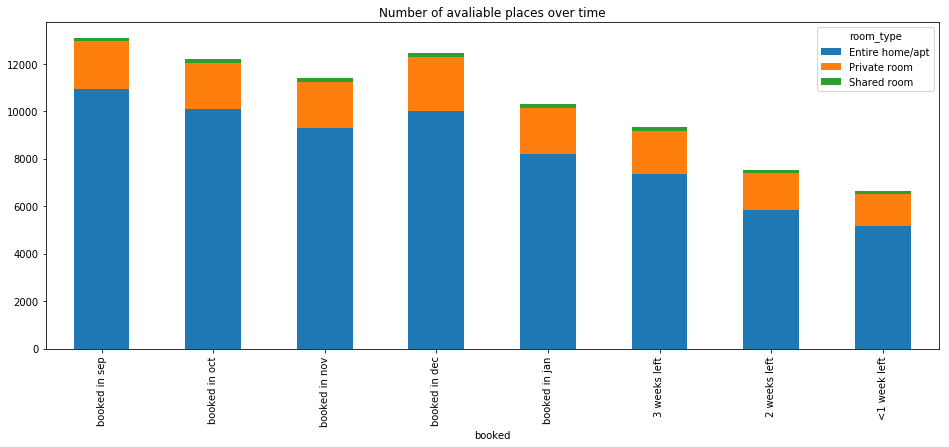

In [51]:
pd.concat([m2, w2]).plot(kind ='bar', stacked = True, title = 'Number of avaliable places over time', figsize = (16, 6));

In [92]:
(
    pd
    .concat([m, w])
    .iplot(filename = 'paris_counts_2', 
           mode = 'lines+markers',
           layout = graph_objs.Layout(title = '"Entire apartments" are booked at a higher rate than "Private rooms"',
                                      yaxis = dict(tickformat = '%a', title = 'Share of available listings', range = (0, 1)))
          )
)

# Instant bookable

In [127]:
instant_list = []
for month in months:
    if month == 'feb':
        continue
    sql = '''
        select instant_bookable, count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '2019-02-08' and '2019-02-10'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) listings
        join {} inst
            on listings.listing_id = inst.id
        group by instant_bookable
        order by instant_bookable
    '''.format('calendar_' + month, 'instant_' + month)
    df = pd.read_sql_query(sql, engine)
    instant_list.append(('booked in ' + month, df.loc[0, 'cnt'], df.loc[1, 'cnt']))

print('instant bookable (f, t): ',  instant_list)

instant bookable (f, t):  [('booked in jan', 6693, 4450), ('booked in dec', 9068, 5532), ('booked in nov', 8731, 5384), ('booked in oct', 10219, 5742), ('booked in sep', 12038, 6410)]


In [106]:
instant_feb = []
for (date_from, date_to) in dates:
    sql = '''
        select instant_bookable, count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) listings
        join instant inst
            on listings.listing_id = inst.id
        group by instant_bookable
        order by instant_bookable
    '''.format('calendar_feb', date_from, date_to)
    df = pd.read_sql_query(sql, engine)
    instant_feb.append((mapper[date_from], df.loc[0, 'cnt'], df.loc[1, 'cnt']))

print('instant bookable (f, t): ',  instant_feb)

instant bookable (f, t):  [('<1 week left', 4267, 2366), ('2 weeks left', 4846, 2685), ('3 weeks left', 5679, 3645)]


In [120]:
mapper

{'2019-02-08': '<1 week left',
 '2019-02-15': '2 weeks left',
 '2019-02-22': '3 weeks left'}

In [160]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 4267, 2366), ('2 weeks left', 4846, 2685), ('3 weeks left', 5679, 3645)], columns = ['month', 'f', 't']),
        pd.DataFrame( [('booked in jan', 6693, 4450), ('booked in dec', 9068, 5532), ('booked in nov', 8731, 5384), ('booked in oct', 10219, 5742), ('booked in sep', 12038, 6410)], columns = ['month', 'f', 't'])
        ])
    .set_index('month')
    [::-1]
    .assign(prop = lambda x: x.t / (x.t + x.f))
    .iplot(y = 'prop', mode = 'lines+markers', filename = 'paris_instant_bookable',
           layout = graph_objs.Layout(yaxis = dict(range = (0.3, 0.5), tickformat = '%a'),
                                      title = '"Instant bookable" places popular when time is running short'))
           
)